# Problem Analysis

In the highly competitive banking industry, it is important for banks to maintain their competitiveness by focusing their marketing efforts on campaigns that generate the highest return on investment (ROI). However, banks often struggle to quantify the ROI for different marketing efforts, making it difficult to determine which campaigns generate the highest profitability and long-term customer value. Therefore, being able to measure and predict the cost-effectiveness of marketing campaigns is crucial for efficient allocation of marketing budgets, ensuring that a bank employs the most effective marketing strategy.

To tackle this challenge, we aim to develop a model that can predict the ROI of various bank marketing campaigns based on key influencing factors such as conversion rate, customer lifetime value (CLV), and acquisition cost. Each of these variables will be estimated using 3 individual models, using campaign-specific features such as campaign type (email marketing, telemarketing, etc), campaign duration, target audience, campaign langauge, and campaign timeframe as inputs. Then, the outputs of these 3 sub-models will be used to develop a model to predict ROI.

Through this, not only are we able to predict and quanitfy the cost-effectiveness of a given marketing campaign, but also that of a general marketing strategy. By identifying the most cost-effective approach, banks can make data-driven decisions to improve their marketing strategies.


General outline:
1. using customer_id as the shared column, join engagement_details with customer.csv, adding the CLV column from customer.csv to engagement_details
2. in the engagement_details dataset, perform a GROUP BY, with the grouping being determined by campaign_id. the resulting table at this step should have the columns campaign_id, and avg_CLV
to obtain avg_CLV: calculate the average CLV for each campaign across various engagements
3. merge campaigns.csv and the resulting table above on campaign_id. the reuslting dataset should include the following columns:
campaign_id, campaign_type, target_audience, campaign_duration, campaign_language, conversion_rate, acquisition_cost, avg_clv, roi
4. conduct EDA
5. train 3 models to predict CLV, acquisition cost, conversion rate
6. train a model to predict ROI 

# Load datasets

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# load datasets
campaigns_df = pd.read_csv("../../data/processed/campaigns.csv")
customer_df =  pd.read_csv("../../data/processed/customer.csv")
engagement_details_df = pd.read_csv("../../data/processed/engagement_details.csv")
engagement_details_df.head(), customer_df.head(), campaigns_df.head()
campaigns_df

,campaign_id,campaign_type,target_audience,campaign_duration,conversion_rate,acquisition_cost,roi,campaign_language,impressions,clicks
0,50,Display Advertising,35-44,45,0.0447,12246.83,4.78,German,48072,2149.0
1,70,Affiliate Marketing,25-34,45,0.1374,16658.91,4.18,French,12180,1674.0
2,89,Telemarketing,45-54,45,0.0647,17649.59,4.30,German,48028,NaN
3,27,Display Advertising,35-44,45,0.0992,6897.91,3.75,French,14504,1439.0
4,72,Display Advertising,35-44,30,0.0880,7144.46,3.11,English,27811,2447.0
...,...,...,...,...,...,...,...,...,...,...
94,3,Email Marketing,35-44,30,0.0656,4098.96,3.01,French,33782,2216.0
95,77,Display Advertising,45-54,60,0.0316,8296.65,2.69,German,29179,922.0
96,75,Display Advertising,45-54,60,0.0379,6223.27,4.28,Mandarin,18497,701.0
97,20,Search Engine Optimization,25-34,30,0.1804,14319.03,4.61,English,9445,1704.0


# Data preprocessing
#### Obtain derived variables

In [9]:
# Join engagement_details with customer.csv on customer_id, adding CLV column
engagement_details_with_clv = engagement_details_df.merge(
    customer_df[['customer_id', 'customer_lifetime_value']],
    on='customer_id',
    how='left'
)

# Compute the average CLV per campaign
avg_clv_per_campaign = engagement_details_with_clv.groupby('campaign_id', as_index=False)['customer_lifetime_value'].mean()
avg_clv_per_campaign.rename(columns={'customer_lifetime_value': 'avg_clv'}, inplace=True)

# Merge campaigns.csv with avg_clv_per_campaign on campaign_id
merged_campaigns = campaigns_df.merge(avg_clv_per_campaign, on='campaign_id', how='left')

# Select and rearrange the required columns
df = merged_campaigns[['campaign_id', 'campaign_type', 'target_audience', 'campaign_duration',
                       'campaign_language', 'conversion_rate', 'acquisition_cost', 'avg_clv', 'roi']]
df

,campaign_id,campaign_type,target_audience,campaign_duration,campaign_language,conversion_rate,acquisition_cost,avg_clv,roi
0,50,Display Advertising,35-44,45,German,0.0447,12246.83,347.264250,4.78
1,70,Affiliate Marketing,25-34,45,French,0.1374,16658.91,321.060719,4.18
2,89,Telemarketing,45-54,45,German,0.0647,17649.59,349.787472,4.30
3,27,Display Advertising,35-44,45,French,0.0992,6897.91,331.085817,3.75
4,72,Display Advertising,35-44,30,English,0.0880,7144.46,352.330993,3.11
...,...,...,...,...,...,...,...,...,...
94,3,Email Marketing,35-44,30,French,0.0656,4098.96,320.244777,3.01
95,77,Display Advertising,45-54,60,German,0.0316,8296.65,340.882099,2.69
96,75,Display Advertising,45-54,60,Mandarin,0.0379,6223.27,339.001862,4.28
97,20,Search Engine Optimization,25-34,30,English,0.1804,14319.03,316.701126,4.61


In [10]:
distinct_values = {
    'campaign_duration': sorted(df['campaign_duration'].unique()),
    'campaign_type': sorted(df['campaign_type'].unique()),
    'target_audience': sorted(df['target_audience'].unique()),
    'campaign_language': sorted(df['campaign_language'].unique())
}

distinct_values

{'campaign_duration': [15, 30, 45, 60, 75],
 'campaign_type': ['Affiliate Marketing',
  'Display Advertising',
  'Email Marketing',
  'Search Engine Optimization',
  'Telemarketing'],
 'target_audience': ['18-24', '25-34', '35-44', '45-54', '55+'],
 'campaign_language': ['English', 'French', 'German', 'Mandarin', 'Spanish']}

# Exploratory Data Analysis

#### Summary Statistics

In [11]:
# Summary statistics and pairplot to explore relationships
summary_stats = df.describe(include='all')
summary_stats

,campaign_id,campaign_type,target_audience,campaign_duration,campaign_language,conversion_rate,acquisition_cost,avg_clv,roi
count,99.000000,99,99,99.000000,99,99.000000,99.000000,99.000000,99.000000
unique,NaN,5,5,NaN,5,NaN,NaN,NaN,NaN
top,NaN,Display Advertising,35-44,NaN,Mandarin,NaN,NaN,NaN,NaN
freq,NaN,38,30,NaN,22,NaN,NaN,NaN,NaN
mean,50.000000,NaN,NaN,39.545455,NaN,0.089924,18448.712323,340.273337,3.337374
std,28.722813,NaN,NaN,20.825942,NaN,0.046705,24413.643916,12.849334,1.030370
min,1.000000,NaN,NaN,15.000000,NaN,0.018600,328.710000,307.812215,1.510000
25%,25.500000,NaN,NaN,15.000000,NaN,0.050900,3338.125000,332.091965,2.500000
50%,50.000000,NaN,NaN,30.000000,NaN,0.081600,10013.410000,340.491696,3.390000
75%,74.500000,NaN,NaN,60.000000,NaN,0.121900,20192.715000,349.444338,4.300000


The variable acquisition_cost has high variability, we will reduce its spread by performing log-transformation.
Furthermore, it also has a significantly larger scale compared to conversion_rate and avg_clv, we should consider feature scaling to ensure consistency across input variables. 

In [12]:
# Log-transform the acquisition_cost column
df['log_acquisition_cost'] = np.log(df.acquisition_cost)
# Encode an order for target_audience
df['target_audience'] = pd.Categorical(df.target_audience, ordered=True)

C:\Users\ashle\AppData\Local\Temp\ipykernel_9272\88596716.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_acquisition_cost'] = np.log(df.acquisition_cost)
C:\Users\ashle\AppData\Local\Temp\ipykernel_9272\88596716.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target_audience'] = pd.Categorical(df.target_audience, ordered=True)


#### Categorical variables
First, let's explore the relationships between the campaign-related features and CLV, acquisition cost, conversion rate and campaign_duration respectively. These insights may drive our model selection for each sub-model.

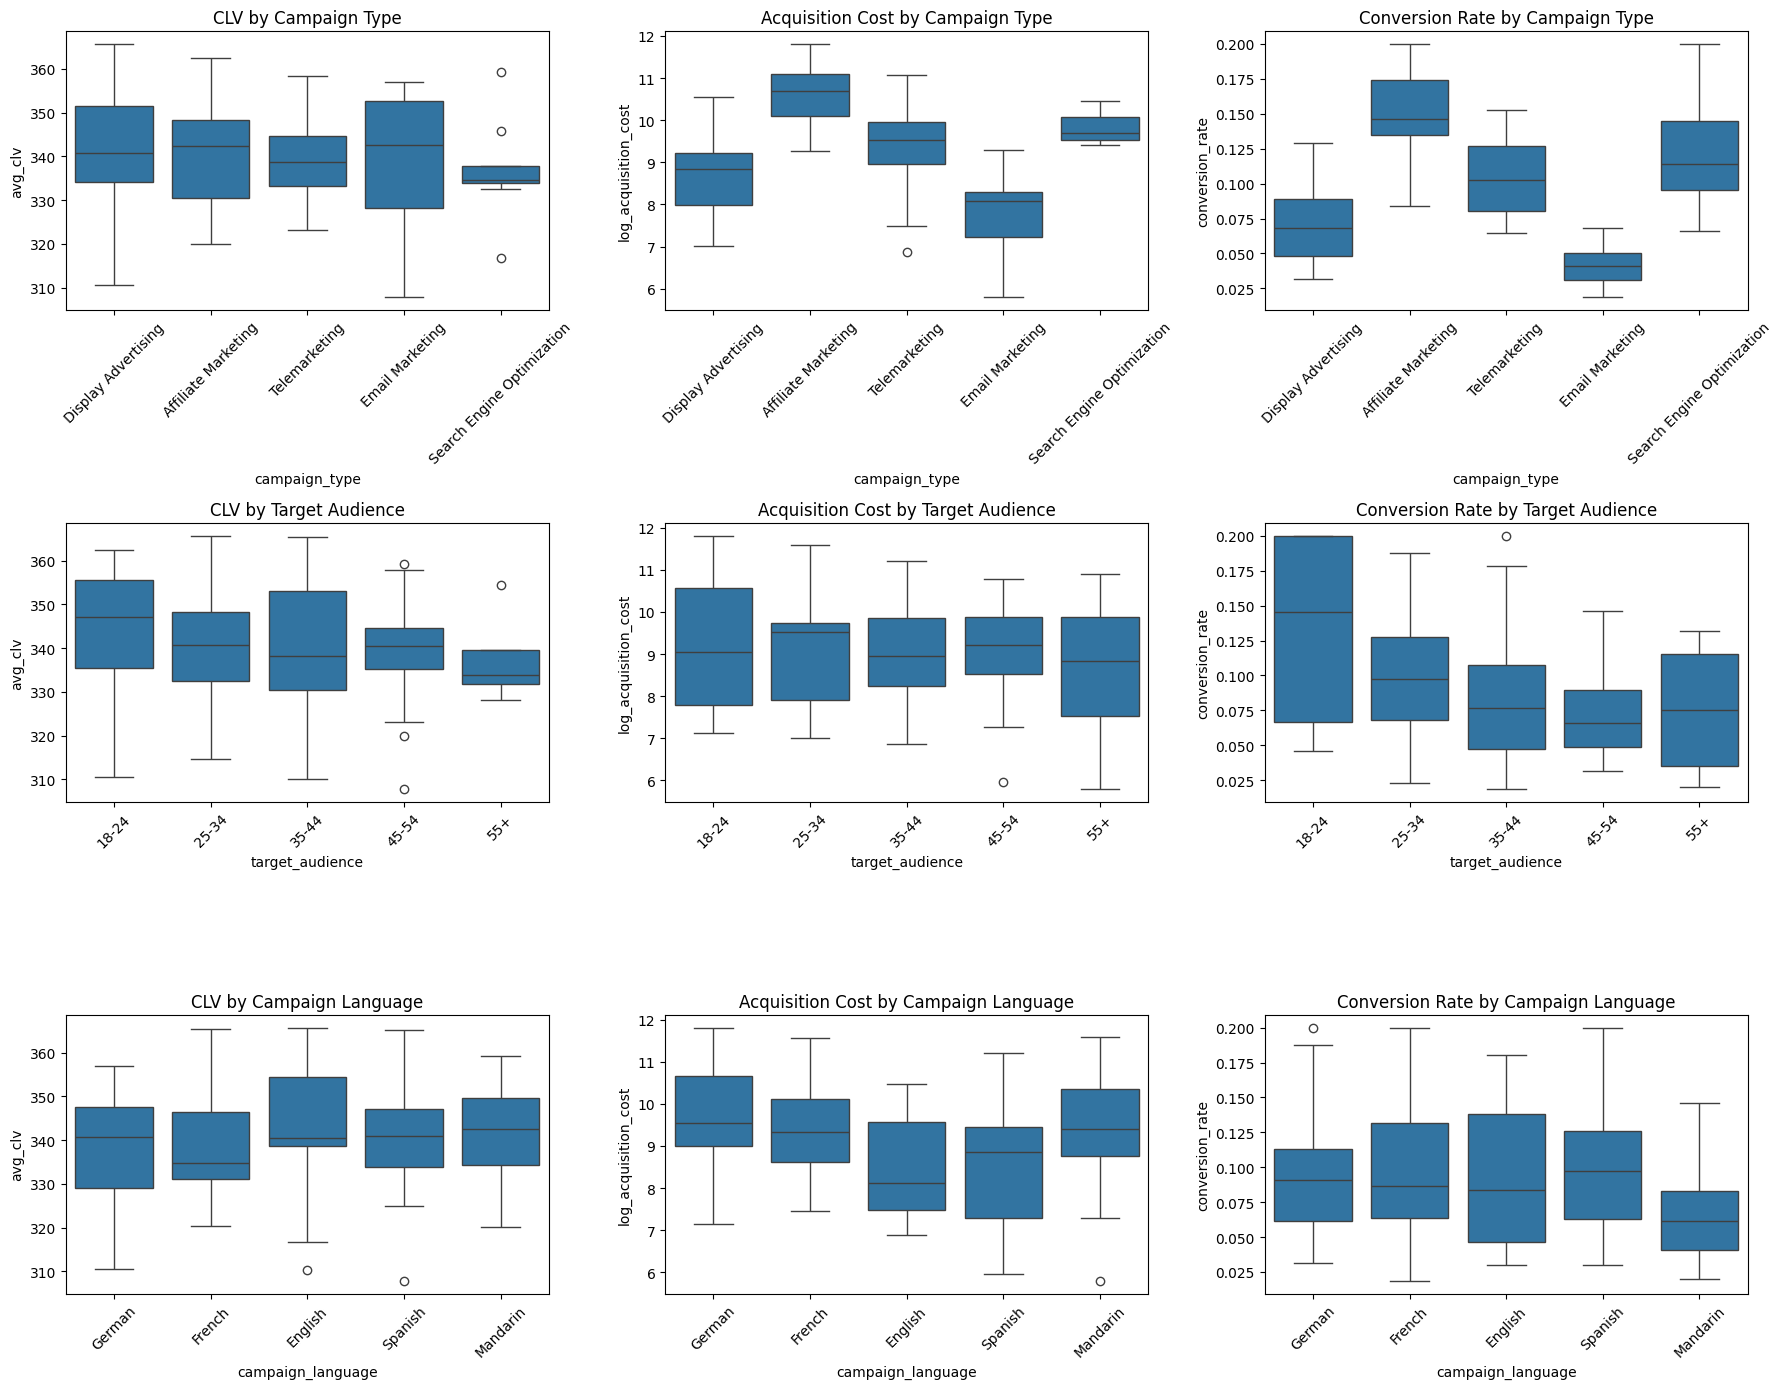

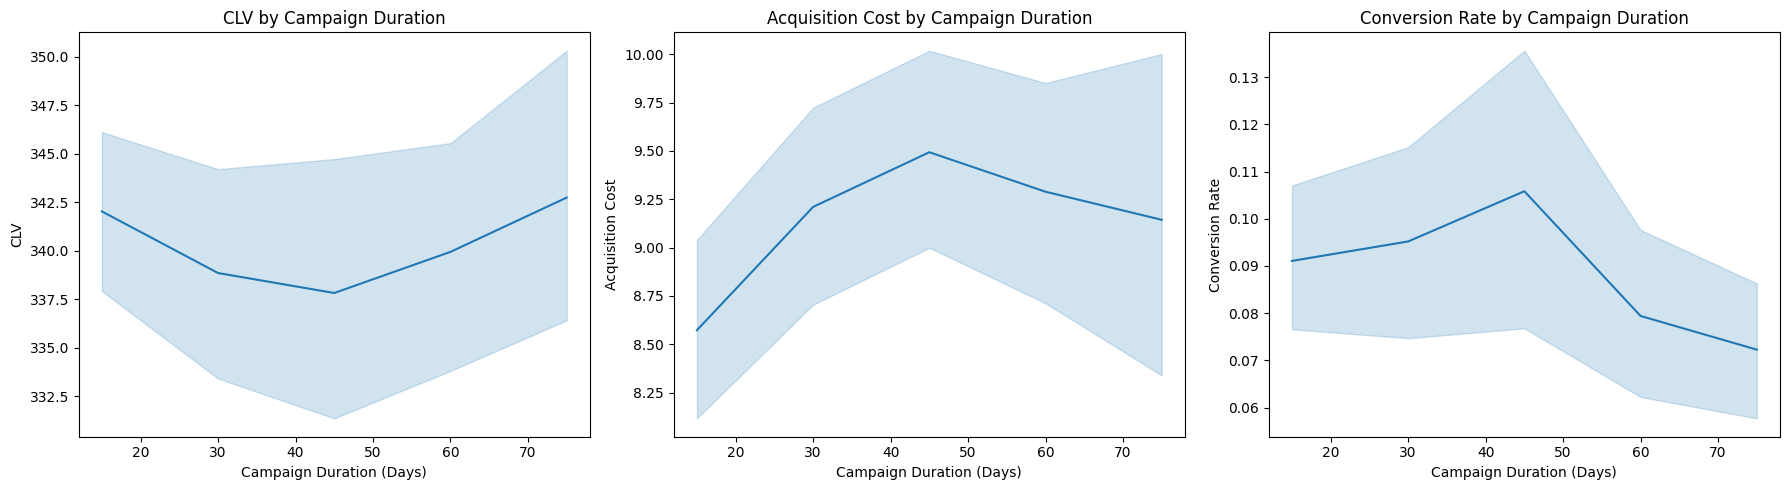

In [13]:
# Configure grid for categorical feature vs CLV, Cost, Conversion Rate
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
categorical_vars = ['campaign_type', 'target_audience', 'campaign_language']
numerical_targets = ['avg_clv', 'log_acquisition_cost', 'conversion_rate']
titles = ['CLV', 'Acquisition Cost', 'Conversion Rate']

# Plot boxplots for categorical features
for i, cat in enumerate(categorical_vars):
    for j, num in enumerate(numerical_targets):
        sns.boxplot(data=df, x=cat, y=num, ax=axes[i, j])
        axes[i, j].set_title(f'{titles[j]} by {cat.replace("_", " ").title()}')
        axes[i, j].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Plot lineplots for campaign_duration vs each numerical target
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for j, num in enumerate(numerical_targets):
    sns.lineplot(data=df, x="campaign_duration", y=num, ax=axes[j])
    axes[j].set_title(f'{titles[j]} by Campaign Duration')
    axes[j].set_xlabel("Campaign Duration (Days)")
    axes[j].set_ylabel(titles[j])

plt.tight_layout()
plt.show()

**CLV model:**\
Email marketing and display advertising has greater variance in CLV, compared to search engine optimisation (SEO), suggesting that the outcomes of these campaigns may be more unpredictable. While each campaign type differs in their variation of CLV, the median CLV for each campaign type is relatively stable among all campaign types. Hence, it may not contribute much to the CLV model, and we may consider dropping it.\ 
CLV increases linearly as the age of the target audience increases, suggesting a slight positive correlation between target audience and CLV.\
Median CLV is relatively stable across languages, suggesting that campaign language has a weaker influence on CLV than other factors. Thus, we will not consider campaign language as an input feature for this sub-model.\ 
As campaign duration increases, the CLV falls, and then increases again. This might suggest a non-linear relationship between campaign duration and CLV.


**Acquisition cost model:**\
Generally, affiliate marketing incurs the greatest cost, followed by telemarketing, SEO, display advertising and email marketing. Campaign type seems to be an important differentiating factor for determining acquisition cost.\
Median acquisition cost is relatively consistent across target age groups. We will drop this feature. \ 
The campaign acquisition cost decreases in from Mandarin, German, French, Spanish, and English. This trend may be attributed to the larger populations of English and Spanish speakers, which makes it more cost-effective to produce campaigns in these languages. English is a universal language, while Portuguese customers may have some familiarity with Spanish due to linguistic similarities and geographical proximity. In contrast, languages like Mandarin and German have more limited speaker bases outside their native regions, increasing the cost of campaign production and outreach.\
There is a slight positive trend between campaign duration and acquisition cost. 


**Conversion Rate model:**\
Generally, affiliate marketing results in the greatest conversion rate, followed by SEO, telemarketing, display advertising and email marketing. \Campaign type seems to be an important differentiating factor for determining conversion rate.\
Generally, conversion rates also decreases as the age of the target group increases.\
Campaign language does not seem to be a strong differentiating feature for conversion rate, we will drop this feature.\ 
On average, the conversion rate is lower when the campaign duration is longer.

#### Summary of approach
**CLV sub-model** \
Input features: 
- target_audience
- camapign_duration

**Acquisition cost sub-model:**\
Input features:
- campaign_type
- target_audience
- camapign_duration

Model:
- Linear Regression: interpretable and simple benchmark


**Conversion rate sub-model:** \
Input features: 
- campaign_type
- target_audience
- camapign_duration


ROI model: TBC

# Acquisition Cost sub-model

In [23]:
# Define features and target
X = df[['campaign_type', 'target_audience', 'campaign_duration']]
y = df['acquisition_cost']

# One-hot encode categorical features
categorical_features = ['campaign_type', 'target_audience']
numerical_features = ['campaign_duration']

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first'), categorical_features),
    ('num', 'passthrough', numerical_features)
])

# Define models
linreg_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Nested cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Function to evaluate model
def evaluate_model(model, X, y):
    predictions = cross_val_predict(model, X, y, cv=kf)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, predictions)
    
    # Calculate adjusted R-squared
    n = X.shape[0]
    preprocessor.fit(X)
    p = model.named_steps['preprocessor'].transform(X).shape[1]
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    return {'MSE': mse, 'RMSE': rmse, 'R2': r2, 'Adj_R2': adj_r2}

# Evaluate both models
linreg_results = evaluate_model(linreg_model, X, y)
linreg_results

{'MSE': 285680822.4719332,
 'RMSE': 16902.09520952752,
 'R2': 0.5157997664292933,
 'Adj_R2': 0.46683569786596335}

# CLV sub-model

Since the dataset is small, it is difficult to get a good estimate of the model performance on the test set. We will thus incoprorate N-fold Cross Validation to calcualte the average value of each performance metric.